# Vietnam THOR dataset plots

## Links

* https://programminghistorian.org/en/lessons/visualizing-with-bokeh

In [1]:
import os, io, random
import string
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from collections import OrderedDict
import datetime as dt
import geopandas as gpd

/usr/local/lib/python3.9/dist-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, Slider, CustomJS, DatePicker
from bokeh.plotting import figure
from bokeh.themes import Theme
from bokeh.io import show, output_notebook
from bokeh.models import (DataTable, GeoJSONDataSource, ColumnDataSource, HoverTool, renderers,
                          Label, LabelSet, CustomJS, MultiSelect, Dropdown, Div)
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
output_notebook()
import panel as pn
import panel.widgets as pnw
pn.extension()

Loading BokehJS ...

In [3]:
borders= gpd.read_file('SE_ASIA_PROVINCES_SV_NV_KH_LA.shp')
laosmap=borders[borders.COUNTRY=='LA']

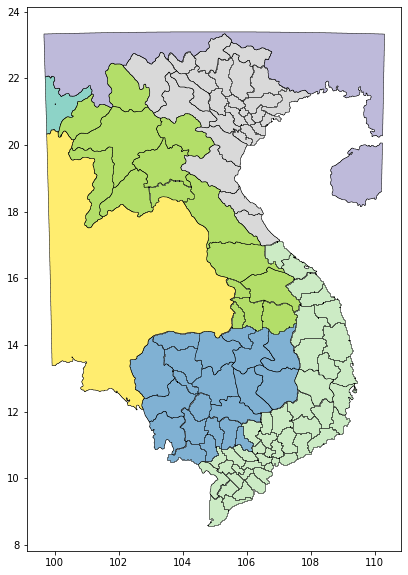

In [4]:
borders.plot(column='COUNTRY',cmap='Set3',lw=.5,ec='black',figsize=(10,10))
plt.savefig('seasia_map.jpg',dpi=150)

In [5]:
def wgs84_to_web_mercator(df, lon="LON", lat="LAT"):
    """convert mat long to web mercartor"""

    k = 6378137
    df.loc[:,"x"] = df[lon] * (k * np.pi/180.0)
    df.loc[:,"y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

In [ ]:
#df=pd.read_csv('thor_data_vietnam.csv', low_memory=False)

## get subset of columns

In [6]:
cols = ['MSNDATE','TGTCOUNTRY','TAKEOFFLOCATION','WEAPONTYPE','MFUNC_DESC','TGTLATDD_DDD_WGS84','TGTLONDDD_DDD_WGS84']
#s=df[cols]
#s=s.sort_values('MSNDATE')
#s.to_csv('thor_data_vietnam_small.csv')

In [7]:
s=pd.read_csv('thor_data_vietnam_small.csv', low_memory=False,index_col=0)
s['MSNDATE'] = pd.to_datetime(s.MSNDATE, format='%Y/%m/%d',errors='coerce')
s['YEAR'] = s.MSNDATE.dt.year.fillna(0).astype(int)
s['MONTH'] = s.MSNDATE.dt.month.fillna(0).astype(int)
s['MONTHNAME'] = s.MSNDATE.dt.month_name()
s=s[s.YEAR>0]
s = wgs84_to_web_mercator(s, lon="TGTLONDDD_DDD_WGS84", lat="TGTLATDD_DDD_WGS84")

/usr/lib/python3/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
#filter
x = s[~s.TGTLATDD_DDD_WGS84.isnull()].copy()
countries = ['NORTH VIETNAM','SOUTH VIETNAM','LAOS','THAILAND','CAMBODIA']
x = x[x.TGTCOUNTRY.isin(countries)]

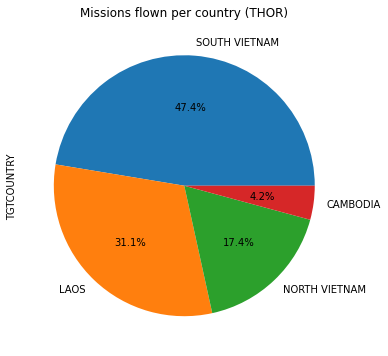

In [9]:
c = x.TGTCOUNTRY.value_counts()
c[:-1].plot(kind='pie',autopct='%1.1f%%',figsize=(6,6))
plt.title('Missions flown per country (THOR)')
plt.savefig('thor_seasia_summary_totals.jpg',dpi=100)

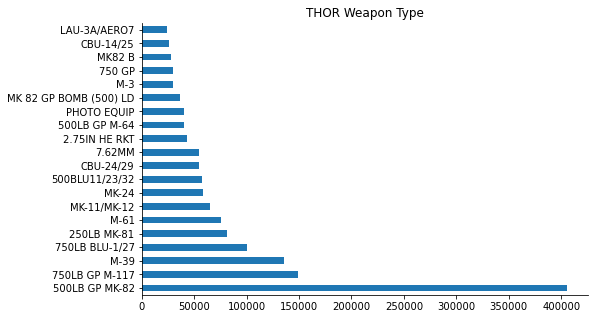

In [10]:
w = x.WEAPONTYPE.value_counts()
w[:20].plot(kind='barh',figsize=(8,5))
plt.title('THOR Weapon Type')
sns.despine()
plt.savefig('thor_seasia_weapontype.jpg',dpi=100)

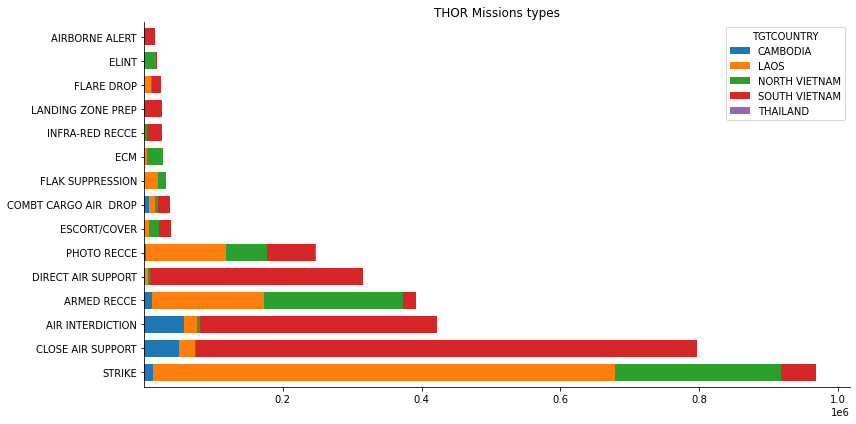

In [11]:
ms=x.MFUNC_DESC.value_counts()
mm = pd.pivot_table(x,index='MFUNC_DESC',columns=['TGTCOUNTRY'],values='x',aggfunc='size')
mm=mm.loc[ms.index[:15]]
mm.plot(kind='barh',stacked=True,width=.7,figsize=(12,6))
plt.title('THOR Missions types')
plt.tight_layout()
sns.despine()
plt.savefig('thor_seasia_mission_types.jpg',dpi=120)

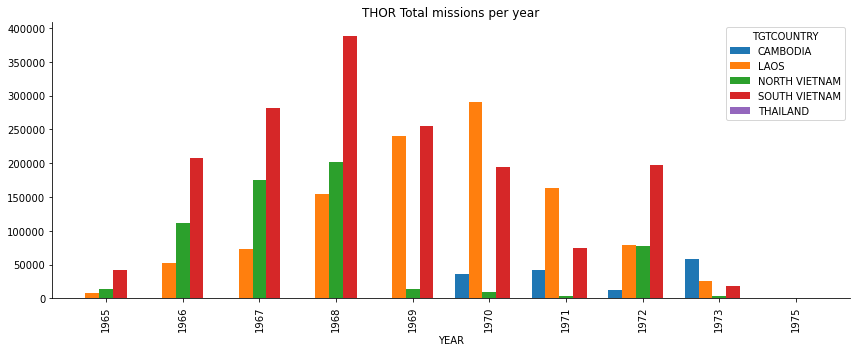

In [12]:
y=pd.pivot_table(x,index='YEAR',columns=['TGTCOUNTRY'],values='x',aggfunc='size')
y.plot(kind='bar',width=.9,figsize=(12,5))
plt.title('THOR Total missions per year')
plt.tight_layout()
sns.despine()
plt.savefig('thor_seasia_summary_byyear.jpg',dpi=120)

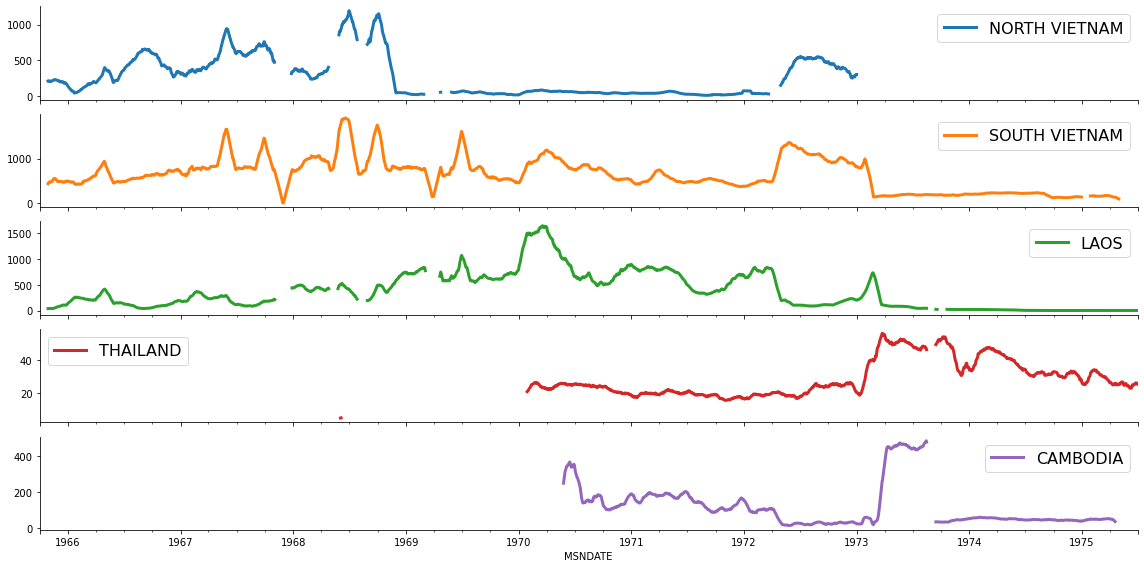

In [13]:
ts=pd.pivot_table(s,index='MSNDATE',columns=['TGTCOUNTRY'],values='x',aggfunc='size')[countries]
ts=ts.rolling(window=28).mean()
plt.rc('legend',fontsize=16) 
ax=ts.plot(lw=3,subplots=True,figsize=(16,8))
sns.despine()
plt.tight_layout()
plt.savefig('thor_seasia_time_series.jpg',dpi=120)

## laos

In [14]:
laos=x[x.TGTCOUNTRY=='LAOS']
gdf=gpd.GeoDataFrame(laos, geometry=gpd.points_from_xy(laos.TGTLONDDD_DDD_WGS84, laos.TGTLATDD_DDD_WGS84),crs="EPSG:4326")
laos=laos.sort_values(['YEAR','MONTH'])

In [ ]:
f,ax=plt.subplots(3,3,figsize=(18,12))
axs=list(ax.flat)
i=0
for y,g in gdf.groupby('YEAR'):
    ax=axs[i]
    borders.plot(column='COUNTRY',cmap='Set2',lw=.2,ec='gray',ax=ax)
    g.plot(color='red',markersize=1,alpha=.5,ax=ax)
    ax.set_xlim(100,110)
    ax.set_ylim(13,23)
    ax.set_title(y)    
    i+=1
f.suptitle('Bombing of Laos by year',fontsize=20)
plt.tight_layout()
plt.savefig('thor_laos_map_byyear.jpg',dpi=150)

## cluster bombs in laos

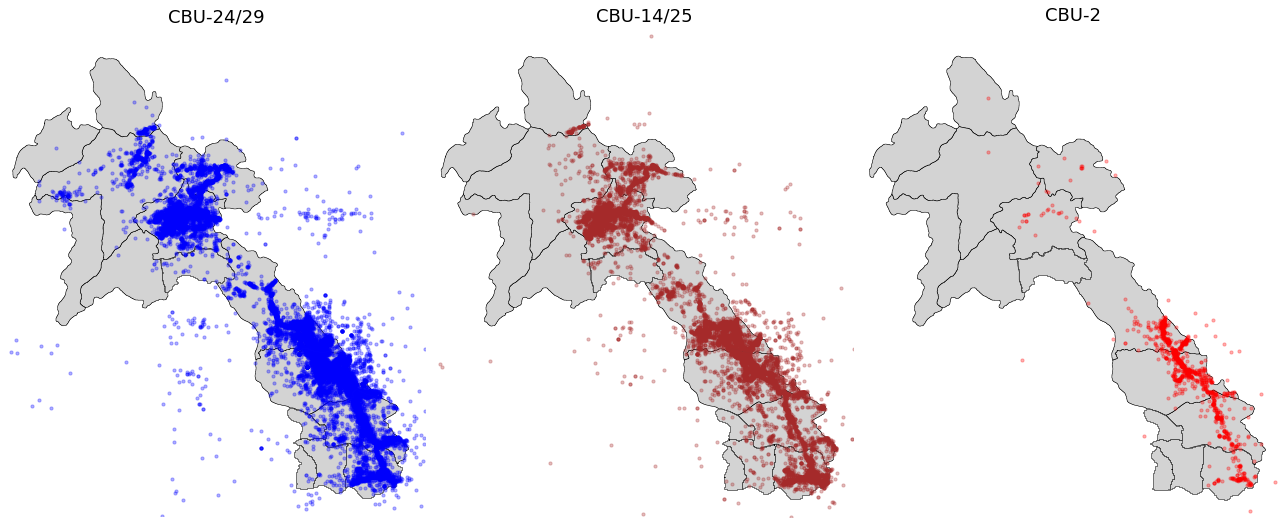

In [15]:
cluster_types=['CBU-24/29','CBU-14/25','CBU-2']
f,ax=plt.subplots(1,3,figsize=(18,12))
clrs=['blue','brown','red']
axs=list(ax.flat)
i=0
for c in cluster_types:
    ax=axs[i]
    cl = gdf[gdf.WEAPONTYPE==c]    
    laosmap.plot(color='lightgray',lw=.5,ec='black',ax=ax)
    cl.plot(color=clrs[i],markersize=10,alpha=.3,ax=ax)
    ax.set_xlim(100,108);ax.set_ylim(14,23)
    ax.set_title(c,fontsize=18)
    ax.axis('off')
    i+=1
plt.tight_layout()
f.savefig('thor_laos_cluster_bombs.jpg',dpi=150)

## geoplot kdeplot

In [ ]:
import geoplot as gplt
cl = gdf[gdf.WEAPONTYPE=='CBU-24/29']
ax=gplt.kdeplot(
    gdf[:2000], clip=laosmap.geometry,
    shade=True, cmap='Reds', shade_lowest=True,
    projection=gplt.crs.AlbersEqualArea(),figsize=(8, 8))
gplt.polyplot(laosmap, ax=ax, zorder=1)

In [ ]:
import geoplot.crs as gcrs
gplt.quadtree(gdf[:10], nmax=1)
gdf[:10]

## animate the plot

In [504]:
f = plt.figure(figsize=(9,8))
f.suptitle('LAOS BOMBING (THOR data)', fontsize=20)
mpl_pane.object = f
import time
time.sleep(5)
for date,g in gdf.groupby(['YEAR','MONTH'],sort=True):
    plt.clf()
    f.suptitle('LAOS BOMBING (THOR data)', fontsize=20)
    ax=f.add_subplot(label=date)
    laosmap.plot(column='COUNTRY',cmap='Set2',lw=1,ec='black',ax=ax)
    g.plot(color='red',markersize=10,alpha=.4,ax=ax)
    ax.set_xlim(100,108);ax.set_ylim(14,23)
    #ax.set_title(date.strftime("%b %d %Y"), fontsize=20)
    ax.set_title(str(date[0])+' '+str(date[1]), fontsize=20)
    ax.axis('off')
    mpl_pane.object=f
    mpl_pane.param.trigger('object')

plt.clf();

<Figure size 1296x1152 with 0 Axes>

In [ ]:
mpl_pane = pn.pane.Matplotlib(height=600)
mpl_pane

## bokeh plots

In [32]:
colormap={'NORTH VIETNAM':'brown','SOUTH VIETNAM':'orange','LAOS':'red',
                'CAMBODIA':'green','THAILAND':'blue','UNKNOWN':'gray'}
x.MFUNC_DESC.unique()
import matplotlib
cmap = matplotlib.cm.get_cmap('Set1')
#names = cols
#olors = cmap(np.linspace(0, 1, len(names)))
#m={i:c for i, c in zip(names, colors)}

providers = ['CARTODBPOSITRON','STAMEN_TERRAIN','OSM','ESRI_IMAGERY']
cats = ['TGTCOUNTRY','WEAPONTYPE','MFUNC_DESC']

In [33]:
def draw_map(df=None, long=None, lat=None, height=500, colorby='TGTCOUNTRY',
             point_size=5,
              tile_provider='CARTODBPOSITRON'):
    tile_provider = get_provider(tile_provider)
    tools = "pan,wheel_zoom,box_zoom,hover,tap,lasso_select,reset,save"
    sizing_mode='stretch_both'

    # range bounds supplied in web mercator coordinates
    k = 6378137
    pad = 700000
    if lat == None:
        lat = 16
    if long == None:
        long = 108
    x = long * (k * np.pi/180.0)
    y = np.log(np.tan((90 + lat) * np.pi/360.0)) * k
      
    p = figure(x_range=(x-pad, x+pad), y_range=(y-pad, y+pad),
               x_axis_type="mercator", y_axis_type="mercator", tools=tools,
               plot_width=height, plot_height=height, sizing_mode=sizing_mode)
    p.add_tile(tile_provider)
    if df is None:
        return
    df.loc[:,'color'] = [colormap[i] if i in colormap else 'gray' for i in df[colorby]]
    #df['size'] = 10
    source = ColumnDataSource(df)    
    p.circle(x='x', y='y', size=point_size, alpha=0.7, color='color', source=source)#, legend_group=colorby)
    p.toolbar.logo = None    
    p.title.text = "date"
    hover = p.select(dict(type=HoverTool))
    hover.tooltips = OrderedDict([
        ("TGTCOUNTRY", "@TGTCOUNTRY"),
        ("MSNDATE", "@MSNDATE{%F}"),
        ("TAKEOFFLOCATION", "@TAKEOFFLOCATION"),
        ("WEAPONTYPE", "@WEAPONTYPE"),
        ("MFUNC_DESC", "@MFUNC_DESC")     
    ])
    hover.formatters={'@MSNDATE': 'datetime'}
    return p 

## dashboard

In [35]:
def dashboard():
    cols = list(x.columns)
    colorby='TGTCOUNTRY'
    map_pane=pn.pane.Bokeh(width=700)
    df_pane = pn.pane.DataFrame(width=600,height=600)
    date_picker = pnw.DatePicker(name='Pick Date',width=200)
    from datetime import date  
    date_picker.value=date(1965, 1, 1)    
    date_slider = pnw.DateSlider(name='Date', start=dt.datetime(1965, 1, 1), 
                                 end=dt.datetime(1973, 10, 31), value=dt.datetime(1968, 1, 1))      
    tile_select = pnw.Select(name='tile layer',options=providers,width=200)
    filterby_select = pnw.Select(name='filter by',value='',options=['']+cols[1:4],width=200)
    value_select = pnw.Select(name='value',value='',options=[],width=200)
    find_btn = pnw.Button(name='find in region',button_type='primary',width=200)

    def update_tile(event=None):
        p = map_pane.object
        p.renderers = [x for x in p.renderers if not str(x).startswith('TileRenderer')]
        rend = renderers.TileRenderer(tile_source= get_provider(tile_select.value))
        p.renderers.insert(0, rend)

    def update_filter(event):
        col=filterby_select.value
        if col=='':
            value_select.options = []
        else:
            value_select.options = sorted(list(x[col].dropna().unique()))

    def find_in_region(event):
        #get points in selected map area
        p = map_pane.object
        source = p.renderers[1].data_source
        d = x[(x.x>p.x_range.start) & (x.x<p.x_range.end) & (x.y>p.y_range.start) & (x.y<p.y_range.end)]
        #add any filter
        d = do_filter(d)
        if len(d)==0:
            return
        elif len(d)>25000:           
            p.title.text = 'too many points!'
        else: 
            d.loc[:,'color'] = [colormap[i] if i in colormap else 'gray' for i in d[colorby]]        
            source.data = dict(d)
            p.title.text = 'selected %s points' %len(d)
        map_pane.param.trigger('object')     
        return

    def do_filter(d):
        col = filterby_select.value
        val = value_select.value
        if col != '':
            d = d[d[col]==val] 
        return d
    
    def update_date(event):
        date_slider.value = date_picker.value     
        
    def update_map(event=None, date=None):
        p = map_pane.object
        source = p.renderers[1].data_source
        if date == None:
            date = str(date_slider.value)
        d = x[x.MSNDATE==date]
        d = do_filter(d)
        if len(d)==0:
            return  
        d.loc[:,'color'] = [colormap[i] if i in colormap else 'gray' for i in d[colorby]]
        source.data = dict(d)
        p.title.text = date

    sdate='1968-01-01'
    d = x[x.MSNDATE==sdate]
    map_pane.object=draw_map(d) 
    
    date_slider.param.watch(update_map,'value')
    date_picker.param.watch(update_date,'value')
    tile_select.param.watch(update_tile,'value')
    filterby_select.param.watch(update_filter,'value')
    value_select.param.watch(update_map,'value')
    find_btn.on_click(find_in_region)

    dashboard = pn.Column(date_slider,pn.Row(pn.Column(date_picker,tile_select,filterby_select,value_select,find_btn),map_pane))
    return dashboard

app=dashboard()

In [37]:
app

Column
    [0] DateSlider(end=datetime.datetime(1973, ..., name='Date', start=datetime.datetime(1965, ..., value=datetime.date(1966, ...)
    [1] Row
        [0] Column
            [0] DatePicker(name='Pick Date', value=datetime.date(1965, 1, 1), width=200)
            [1] Select(name='tile layer', options=['CARTODBPOSITRON', ...], value='STAMEN_TERRAIN', width=200)
            [2] Select(name='filter by', options=['', 'TGTCOUNTRY', ...], width=200)
            [3] Select(name='value', width=200)
            [4] Button(button_type='primary', name='find in region', width=200)
        [1] Bokeh(Figure, width=700)